In [815]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

### NOTE: The only methods you are required to have are:
#   * predict
#   * fit
#   * score
#   * get_weights
#   They must take at least the parameters below, exactly as specified. The output of
#   get_weights must be in the same format as the example provided.

class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True, max_iter=1000):
        """ Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.delta = None
        self.deltas = []
        self.iteration = 0
        self.max_iter = max_iter

    def fit(self, X, y, initial_weights=None, deterministic=False):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.initial_weights = self.initialize_weights(X) if not initial_weights else initial_weights
        
        self.weights = self.initial_weights.copy()
        self.rates = []
        if deterministic:
            for i in range(deterministic):
                self._epoch(X, y)
                self.iteration += 1
        else:
            scale = max(np.abs(X).mean(axis=0)) * (X.shape[1] / 3)
            eps = self.lr * scale
            converged = True
            for i in range(5):
                self._epoch(X, y)
                self.iteration += 1
                self.rates.append(self.miscl_rate)
            while np.linalg.norm(self.deltas) > eps:
                self._epoch(X, y)
                self.iteration += 1
                self.rates.append(self.miscl_rate)
                if self.iteration >= self.max_iter:
                    converged = False
                    break
            if converged:
                print("Classifer converged after {} iterations.".format(self.iteration))
            else:
                print("Maximum number of iterations reached.")
        return self
    
    def _epoch(self, X, y):
        """ 
        Run an epoch through the training dataset X, y
        Args: 
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        """
        initial_weights = self.weights.copy()
        self.miscl_rate = 0
        if self.shuffle:
            _X, _y = self._shuffle_data(X, y)
        else:
            _X, _y = X, y
        for x,t in zip(_X, _y):
            pattern = np.append(x, 1)
            output = 0 if np.dot(self.weights, pattern) <= 0 else 1
            self.weights += self.lr * (t[0] - output) * pattern
            self.miscl_rate += int(t[0] == output)
        self.miscl_rate /= len(y)
        self.delta = max(np.abs(self.weights - initial_weights))
        if len(self.deltas) < 5:
            self.deltas.append(self.delta)
        else:
            self.deltas.pop(0)
            self.deltas.append(self.delta)

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        pred = []
        for x in X:
            pattern = np.append(x, 1)
            output = 0 if np.dot(self.weights, pattern) <= 0 else 1
            pred.append(output)
        return np.array(pred).reshape(-1, 1)

    def initialize_weights(self, X):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """

        return np.zeros(X.shape[1] + 1)

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        pred = self.predict(X)
        return sum(pred==y)[0] / len(y)

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        Xy = np.hstack([X, y])
        np.random.shuffle(Xy)
        return Xy[:, :-1], Xy[:, -1].reshape(-1, 1)

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

def train_test_split(X, y, train_size=0.7, shuffle=True):
    """Split the data into train and test sets
    Args:
        X (array-like): A 2D numpy array with the training data, excluding targets
        y (array-like): A 2D numpy array with the training targets
        train_size (float): Percentage of the data that will be used for training;
            Test size is automatically set to 1 - train_size
        shuffle (bool): Whether to shuffle the dataset or not
    Returns:
        X_train (array-like): A 2D numpy array with the inputs of the training data
        y_train (array-like): A 2D numpy array with the targets of the training data
        X_test (array-like): A 2D numpy array with the inputs of the test data
        y_test (array-like): A 2D numpy array with the targets of the test data
    """
    split = int(train_size * X.shape[0])
    Xy = np.hstack([X, y])
    if shuffle:
        np.random.shuffle(Xy)
    Xy_train = Xy[:split]
    Xy_test = Xy[split:]
    return Xy_train[:,:-1], Xy_train[:,-1].reshape(-1, 1), \
           Xy_test[:,:-1], Xy_test[:,-1].reshape(-1, 1)
    

In [414]:
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt

# Debug dataset

[(-0.4,  0.3, b'1') (-0.3,  0.8, b'1') (-0.2,  0.3, b'1')
 (-0.1,  0.9, b'1') (-0.1,  0.1, b'0') ( 0. , -0.2, b'0')
 ( 0.1,  0.2, b'0') ( 0.2, -0.2, b'0')]
Dataset: linSep2nonorigin
	a1's type is numeric
	a2's type is numeric
	class's type is nominal, range is ('0', '1')

Final weights: [-0.23  0.18 -0.1 ]
Accuracy: 0.88


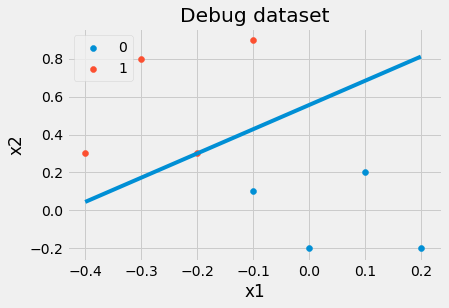

In [770]:
data, meta = arff.loadarff("linsep2nonorigin.arff")
print(data)
print(meta)
X = np.stack([data['a1'], data['a2']]).T
y_a = data['class'].astype(int)
y = y_a.reshape(-1, 1)
perceptron = PerceptronClassifier(lr=.1, shuffle=False)
perceptron.fit(X, y, deterministic=10)
w = perceptron.get_weights()
acc = perceptron.score(X, y)
print("Final weights: {}".format(w))
print("Accuracy: {:.2f}".format(acc))
plt.scatter(X[:,0][y_a==0], X[:,1][y_a==0], label='0')
plt.scatter(X[:,0][y_a==1], X[:,1][y_a==1], label='1')
domain = np.linspace(-0.4, 0.2, 10)
plt.plot(domain, -w[0]/w[1] * domain - w[2]/w[1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Debug dataset")
plt.legend()
plt.show()

# Evaluation dataset

In [771]:
data, meta = arff.loadarff("data_banknote_authentication.arff")
print(data)
print(meta)
fields = []
for n in data.dtype.fields.items():
    fields.append(n[0])
X = np.stack([data[f] for f in fields[:-1]]).T
y = data[fields[-1]].astype(int).reshape(-1, 1)
print(X.shape, y.shape)
perceptron = PerceptronClassifier(lr=0.1, shuffle=False)
perceptron.fit(X, y, deterministic=10)
w = perceptron.get_weights()
acc = perceptron.score(X, y)
print("Final weights: {}".format(w))
print("Accuracy: {:.2f}".format(acc))

[( 3.6216,   8.6661 , -2.8073, -0.44699, b'0')
 ( 4.5459,   8.1674 , -2.4586, -1.4621 , b'0')
 ( 3.866 ,  -2.6383 ,  1.9242,  0.10645, b'0') ...
 (-3.7503, -13.4586 , 17.5932, -2.7771 , b'1')
 (-3.5637,  -8.3827 , 12.393 , -1.2823 , b'1')
 (-2.5419,  -0.65804,  2.6842,  1.1952 , b'1')]
Dataset: Banknote_Authenitication
	variance_wavelet's type is numeric
	skewness_wavelet's type is numeric
	curtosis_wavelet's type is numeric
	entropy_wavelet's type is numeric
	class's type is nominal, range is ('0', '1')

(1372, 4) (1372, 1)
Final weights: [-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]
Accuracy: 0.99


# Linearly separable dataset

In [354]:
X = np.random.uniform(-1, 1, size=(8,2))

[[ 0.19741597 -0.87408212]
 [ 0.77847305 -0.35361788]
 [ 0.97622759 -0.27068389]
 [ 0.05865783 -0.82223101]
 [-0.19563794 -0.3737767 ]
 [ 0.01940362  0.42199833]
 [-0.91932312  0.85053846]
 [ 0.20271421  0.90344603]]


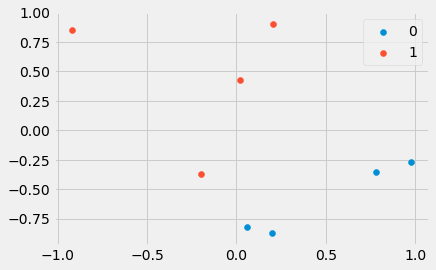

In [357]:
print(X)
y_a = np.array([0, 0, 0, 0, 1, 1, 1, 1])
y = y_a.reshape(-1, 1)
plt.scatter(X[:, 0][y_a==0], X[:, 1][y_a==0], label=0)
plt.scatter(X[:, 0][y_a==1], X[:, 1][y_a==1], label=1)
plt.legend()
plt.show()

[( 0.19741597, -0.87408212, b'0') ( 0.77847305, -0.35361788, b'0')
 ( 0.97622759, -0.27068389, b'0') ( 0.05865783, -0.82223101, b'0')
 (-0.19563794, -0.3737767 , b'1') ( 0.01940362,  0.42199833, b'1')
 (-0.91932312,  0.85053846, b'1') ( 0.20271421,  0.90344603, b'1')]
Dataset: separable
	a1's type is numeric
	a2's type is numeric
	class's type is nominal, range is ('0', '1')

Classifer converged after 7 iterations.
Final weights: [-1.4261613e-06  3.4536150e-07  0.0000000e+00]
Accuracy: 1.00


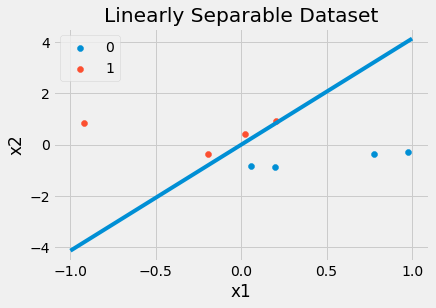

In [772]:
data, meta = arff.loadarff("separable.arff")
print(data)
print(meta)
X = np.stack([data['a1'], data['a2']]).T
y_a = data['class'].astype(int)
y = y_a.reshape(-1, 1)
perceptron = PerceptronClassifier(lr=.000001, shuffle=True)
perceptron.fit(X, y)
w = perceptron.get_weights()
acc = perceptron.score(X, y)
print("Final weights: {}".format(w))
print("Accuracy: {:.2f}".format(acc))
plt.scatter(X[:,0][y_a==0], X[:,1][y_a==0], label='0')
plt.scatter(X[:,0][y_a==1], X[:,1][y_a==1], label='1')
domain = np.linspace(-1, 1, 10)
plt.plot(domain, -w[0]/w[1] * domain - w[2]/w[1])
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Linearly Separable Dataset")
plt.show()

In [363]:
for i in range(5):
    perceptron = PerceptronClassifier(lr=10**(-i), shuffle=True)
    perceptron.fit(X, y)

Classifer converged after 9 iterations.
Classifer converged after 10 iterations.
Classifer converged after 7 iterations.
Classifer converged after 7 iterations.
Classifer converged after 8 iterations.


# Non-separable dataset

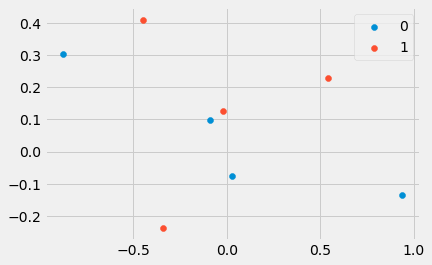

[[-0.09198194  0.0981303 ]
 [ 0.93617818 -0.13420586]
 [ 0.02919202 -0.0764347 ]
 [-0.87609183  0.30259859]
 [-0.45058894  0.40980197]
 [-0.01943979  0.12687661]
 [-0.34174554 -0.23565382]
 [ 0.54322313  0.22779957]] [0 0 0 0 1 1 1 1]


In [366]:
X = np.random.uniform(-1, 1, size=(8,2))
y_a = np.array([0, 0, 0, 0, 1, 1, 1, 1])
y = y_a.reshape(-1, 1)
plt.scatter(X[:, 0][y_a==0], X[:, 1][y_a==0], label=0)
plt.scatter(X[:, 0][y_a==1], X[:, 1][y_a==1], label=1)
plt.legend()
plt.show()
print(X, y_a)

[(-0.09198194,  0.0981303 , b'0') ( 0.93617818, -0.13420586, b'0')
 ( 0.02919202, -0.0764347 , b'0') (-0.87609183,  0.30259859, b'0')
 (-0.45058894,  0.40980197, b'1') (-0.01943979,  0.12687661, b'1')
 (-0.34174554, -0.23565382, b'1') ( 0.54322313,  0.22779957, b'1')]
Dataset: nonseparable
	a1's type is numeric
	a2's type is numeric
	class's type is nominal, range is ('0', '1')

Maximum number of iterations reached.
Final weights: [-0.0085904  0.0097415  0.       ]
Accuracy: 0.62


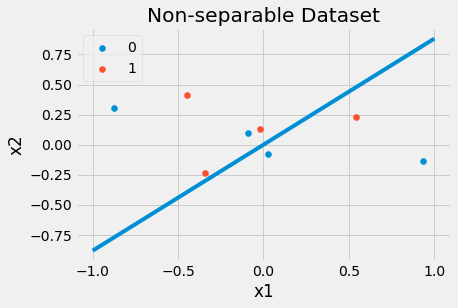

In [774]:
data, meta = arff.loadarff("nonseparable.arff")
print(data)
print(meta)
X = np.stack([data['a1'], data['a2']]).T
y_a = data['class'].astype(int)
y = y_a.reshape(-1, 1)
perceptron = PerceptronClassifier(lr=.01, shuffle=True)
perceptron.fit(X, y)
w = perceptron.get_weights()
acc = perceptron.score(X, y)
print("Final weights: {}".format(w))
print("Accuracy: {:.2f}".format(acc))
plt.scatter(X[:,0][y_a==0], X[:,1][y_a==0], label='0')
plt.scatter(X[:,0][y_a==1], X[:,1][y_a==1], label='1')
domain = np.linspace(-1, 1, 10)
plt.plot(domain, -w[0]/w[1] * domain - w[2]/w[1])
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Non-separable Dataset")
plt.show()

In [732]:
for i in range(5):
    perceptron = PerceptronClassifier(lr=10**(-i), shuffle=True)
    perceptron.fit(X, y)

Classifer converged after 11 iterations.
Classifer converged after 20 iterations.
Classifer converged after 110 iterations.
Maximum number of iterations reached.
Maximum number of iterations reached.


# Voting data

In [791]:
data, meta = arff.loadarff("voting.arff")
fields = []
for n in data.dtype.fields.items():
    fields.append(n[0])
X = np.stack([data[f] for f in fields[:-1]]).T
X = (X == b"'y'").astype(int)
y = (data[fields[-1]]==b"\'republican'").astype(int).reshape(-1, 1)
X_train, y_train, X_test, y_test = train_test_split(X, y)
print(X.shape, y.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(461, 16) (461, 1)
(322, 16) (322, 1) (139, 16) (139, 1)


In [820]:
np.set_printoptions(precision=2, suppress=True)
rates = []
for i in range(5):
    print("Trial {}".format(i+1))
    X_train, y_train, X_test, y_test = train_test_split(X, y)
    perceptron = PerceptronClassifier(lr=.1, shuffle=True)
    perceptron.fit(X_train, y_train)
    w = perceptron.get_weights()
    acc = perceptron.score(X_test, y_test)
    print("Final weights: {}".format(w))
    print("Accuracy: {:.4f}".format(acc))
    rates.append(perceptron.rates)
    print()

Trial 1
Classifer converged after 40 iterations.
Final weights: [ 0.3 -0.  -0.8  1.7  0.5 -0.3  0.5  1.1 -0.5  0.4 -1.1 -0.1  0.2 -0.1
 -0.6  0.4 -1.5]
Accuracy: 0.9424

Trial 2
Classifer converged after 25 iterations.
Final weights: [ 0.  -0.3 -0.5  1.6  0.4 -0.2  0.3  0.3 -0.7  0.5 -1.1  0.1 -0.1 -0.1
 -0.5  0.5 -1.1]
Accuracy: 0.9353

Trial 3
Classifer converged after 8 iterations.
Final weights: [-0.1 -0.3 -0.4  1.4  0.1 -0.3  0.2  0.4 -0.6  0.5 -0.8  0.   0.2  0.1
 -0.5  0.2 -0.6]
Accuracy: 0.9568

Trial 4
Classifer converged after 48 iterations.
Final weights: [ 0.3 -0.3 -0.7  1.9  0.1 -0.1  0.2  1.1 -0.6  0.5 -1.   0.3  0.  -0.2
 -0.9  0.3 -1.4]
Accuracy: 0.9496

Trial 5
Classifer converged after 7 iterations.
Final weights: [-0.  -0.1 -0.6  1.4  0.2 -0.   0.4  0.6 -0.3  0.3 -0.8  0.2  0.2  0.
 -0.5  0.4 -0.7]
Accuracy: 0.8705



In [827]:
ls = []
for r in rates:
    if len(r) > 36:
        l = r[:36]
    else:
        l = r + [0]*(36 - len(r))
    ls.append(l)
ls = np.asarray(ls)

In [838]:
aves = []
for i in range(36):
    a = 0
    k = 0
    for j in range(5):
        if ls[j,i] > 0:
            a += ls[j,i]
            k += 1
    a /= k
    a = 1 - a
    aves.append(a)

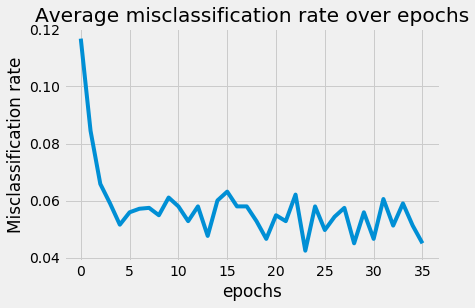

In [841]:
plt.plot(aves)
plt.ylabel("Misclassification rate")
plt.xlabel("epochs")
plt.title("Average misclassification rate over epochs")
plt.show()

## Scikit-learn

In [842]:
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_digits
X_train, y_train, X_test, y_test = train_test_split(X, y)

In [844]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train.ravel())
score = perceptron.score(X_test, y_test.ravel())
print(score)

perceptron = Perceptron(penalty='l2', alpha=.000001)
perceptron.fit(X_train, y_train.ravel())
score = perceptron.score(X_test, y_test.ravel())
print(score)

perceptron = Perceptron(penalty='l1', alpha=.001)
perceptron.fit(X_train, y_train.ravel())
score = perceptron.score(X_test, y_test.ravel())
print(score)

perceptron = Perceptron(eta0=1e-7)
perceptron.fit(X_train, y_train.ravel())
score = perceptron.score(X_test, y_test.ravel())
print(score)

0.9712230215827338
0.9640287769784173
0.9136690647482014
0.9064748201438849


In [542]:
X, y = load_digits(return_X_y=True)
X_train, y_train, X_test, y_test = train_test_split(X, y.reshape(-1, 1))
perceptron = Perceptron()
perceptron.fit(X_train, y_train.ravel())
score = perceptron.score(X_test, y_test.ravel())
print(score)

0.9462962962962963


# Iris dataset

In [719]:
class MulticlassPerceptron(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True, maxiter=1000):
        """ Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.delta = None
        self.deltas = []
        self.iteration = 0
        self.maxiter = maxiter

    def fit(self, X, y, initial_weights=None, deterministic=False):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.c = int(y.max()) + 1
        self.k = X.shape[1]
        self.initial_weights = self.initialize_weights() if not initial_weights else initial_weights
        
        self.weights = self.initial_weights.copy()
        
        if deterministic:
            for i in range(deterministic):
                self._epoch(X, y)
                self.iteration += 1
        else:
            scale = max(np.abs(X).mean(axis=0))
            eps = self.lr * scale
            converged = True
            for i in range(5):
                self._epoch(X, y)
                self.iteration += 1
            while np.linalg.norm(self.deltas) > eps and self.iteration < 10 + 1/self.lr:
                self._epoch(X, y)
                self.iteration += 1
                if self.iteration >= self.maxiter:
                    converged = False
                    break
            if converged:
                print("Classifer converged after {} iterations.".format(self.iteration))
            else:
                print("Maximum number of iterations reached.")
        return self
    
    def _epoch(self, X, y):
        """ 
        Run an epoch through the training dataset X, y
        Args: 
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        """
        initial_weights = self.weights.copy()
        if self.shuffle:
            _X, _y = self._shuffle_data(X, y)
        else:
            _X, _y = X, y
        for x,t in zip(_X, _y):
            t_onehot = np.zeros(self.c)
            t_onehot[int(t[0])] = 1
            pattern = np.append(x, 1)
            output = np.dot(self.weights, pattern).argmax()
            output_onehot = np.zeros(self.c)
            output_onehot[output] = 1
            self.weights += self.lr * (t_onehot - output_onehot).reshape(-1, 1) * pattern
        self.delta = np.abs(self.weights - initial_weights).max()
        if len(self.deltas) < 5:
            self.deltas.append(self.delta)
        else:
            self.deltas.pop(0)
            self.deltas.append(self.delta)

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        pred = []
        for x in X:
            pattern = np.append(x, 1)
            output = np.dot(self.weights, pattern).argmax()
            pred.append(output)
        return np.array(pred).reshape(-1, 1)

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """

        return np.zeros((self.c, self.k + 1))

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        pred = self.predict(X)
        return sum(pred==y)[0] / len(y)

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        Xy = np.hstack([X, y])
        np.random.shuffle(Xy)
        return Xy[:, :-1], Xy[:, -1].reshape(-1, 1)

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

In [856]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)
X_train, y_train, X_test, y_test = train_test_split(X, y)
perceptron = MulticlassPerceptron(lr=0.1)
perceptron.fit(X_train, y_train)
perceptron.get_weights()
acc = perceptron.score(X_test, y_test)
weights = perceptron.get_weights()
print("Final weights: {}".format(weights))
print("Accuracy: {:.4f}".format(acc))

Classifer converged after 20 iterations.
Final weights: [[ 1.83  3.9  -5.25 -2.73  0.9 ]
 [ 2.15  0.25 -1.29 -3.55  1.8 ]
 [-3.98 -4.15  6.54  6.28 -2.7 ]]
Accuracy: 0.9556


In [849]:
len(X_test)

45